## Inpainting with trained Wasserstein-GAN

In [1]:
import numpy as np
import torch
import torch.nn as nn
import h5py

from utils.create_data import sample_check
from utils.tools import random_bbox, mask_image, get_config
from model.networks import Generator

c:\Users\s174370\AppData\Local\miniconda3\envs\dgm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
img_idx = 0
plt_scale = 0.1
rng = np.random.default_rng(0)
exp_path = 'C:/Users/s174370/Desktop/magfield-prediction/checkpoints/boundary_1_256/'
# model = 'in_94_coarseG_l1'
# model = 'in_94_l1'
# model = 'in_94_lightweight'
model = 'in_94_coarseG_l1False' 
exp_path += model

(3, 256, 256)


<Figure size 640x480 with 0 Axes>

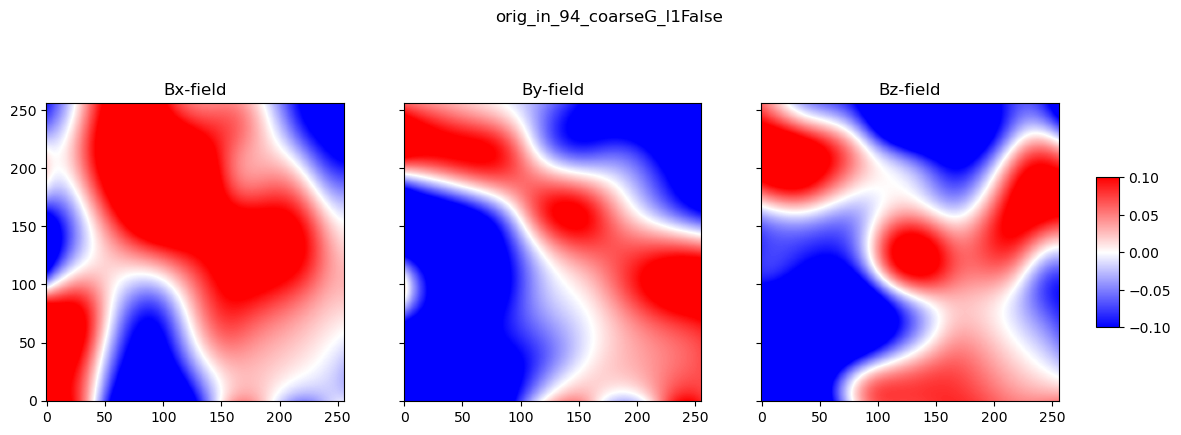

In [3]:
file = h5py.File('data/bnd_256/magfield_256_large.h5') 
print(file['field'][img_idx,:,:,:,1].shape)
field = file['field'][img_idx,:,:,:,1]
sample_check(field, v_max=plt_scale, filename = 'orig_'+model)

(150, 3, 96, 96)


<Figure size 640x480 with 0 Axes>

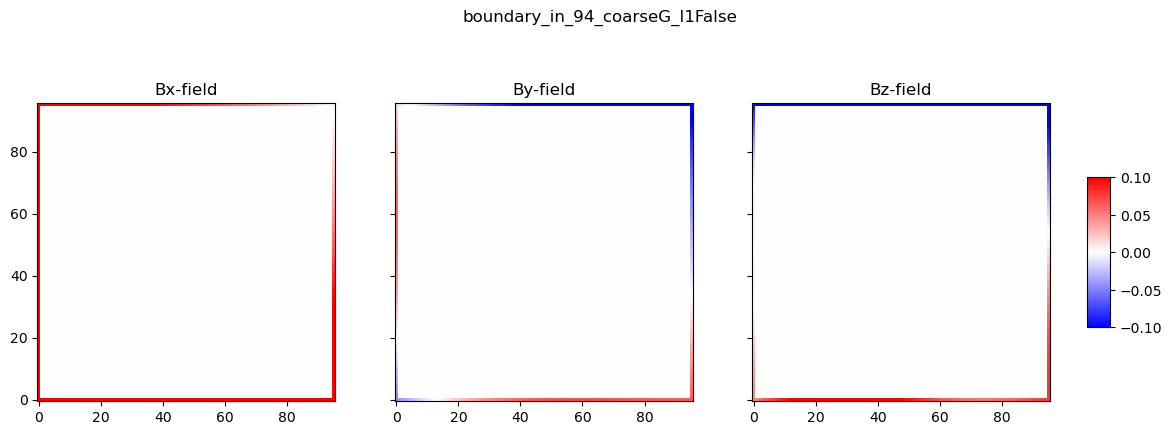

In [4]:
config = get_config(exp_path + '/config.yaml')
bboxes = random_bbox(config, rng=rng)
x, mask, orig = mask_image(np.array([field]), bboxes, config, bnd=config['boundary'])
print(x.shape)
sample_check(x[0], v_max=plt_scale, filename = 'boundary_'+model)


<Figure size 640x480 with 0 Axes>

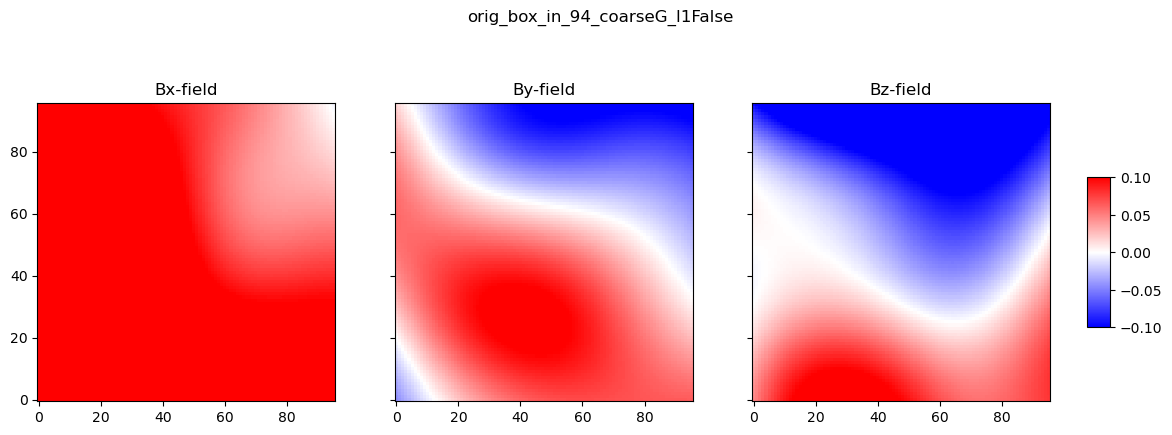

In [5]:
last_model_name = exp_path + '/gen_00400000.pt'
# Generator(config, coarse_G, use_cuda, device_ids)
netG = Generator(config['netG'], config['coarse_G'], True, [0])
netG.load_state_dict(torch.load(last_model_name))
netG = nn.parallel.DataParallel(netG, device_ids=[0])
corrupt_t = torch.from_numpy(x[0].astype('float32')).cuda().unsqueeze(0)
mask_t = torch.from_numpy(mask[0].astype('float32')).cuda().unsqueeze(0)

# Inference
_, out = netG(corrupt_t, mask_t)

sample_check(orig[0], v_max=plt_scale, filename = 'orig_box_'+model)

<Figure size 640x480 with 0 Axes>

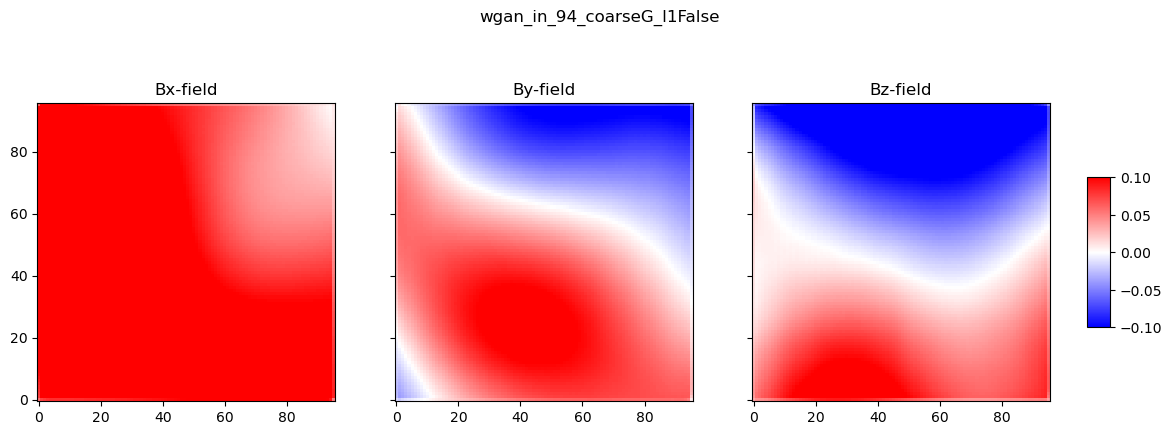

In [6]:
out_np = out.squeeze(0).cpu().data.numpy()
sample_check(out_np, v_max=plt_scale, filename='wgan_'+model)

In [7]:
diff = orig - out_np
mse_final = np.mean(diff**2)
psnr = 20 * np.log10(np.max(orig) / np.sqrt(mse_final))
mape = 100*(np.abs(np.mean(diff)/np.mean(orig)))

print(f"Recon loss: {np.mean(np.abs(diff)):.4f}")
print(f"PSNR: {psnr:.4f} dB")
print(f"MAPE: {mape:.4f} %")


Recon loss: 0.0063
PSNR: 27.7118 dB
MAPE: 6.8181 %


In [9]:
out_stack = torch.from_numpy(out_np)[None, :]

# Div
Hx_x = torch.gradient(out_stack[0,0], dim=1, edge_order=2)[0]
Hy_y = torch.gradient(out_stack[0,1], dim=0, edge_order=2)[0]
if len(out_stack.size()[1:]) > 3 : 
    Hz_z = torch.gradient(out_stack[0,2], dim=2, edge_order=2)[0]
    div_mag = torch.stack([Hx_x, Hy_y, Hz_z], dim=0)[:,:,:,1]
else:
    div_mag = torch.stack([Hx_x, Hy_y], dim=0)
div = torch.mean(torch.abs(div_mag.sum(dim=0)))

#Curl
Hx_y = torch.gradient(out_stack[0,0], dim=0, edge_order=2)[0]
Hy_x = torch.gradient(out_stack[0,1], dim=1, edge_order=2)[0]
if len(out_stack.size()[1:]) > 3 :
    Hx_z = torch.gradient(out_stack[0,0], dim=2, edge_order=2)[0]
    Hy_z = torch.gradient(out_stack[0,1], dim=2, edge_order=2)[0]
    Hz_x = torch.gradient(out_stack[0,2], dim=1, edge_order=2)[0]
    Hz_y = torch.gradient(out_stack[0,2], dim=0, edge_order=2)[0]
    curl_vec = torch.stack([Hz_y - Hy_z, Hx_z - Hz_x, Hy_x - Hx_y], dim=0)[:,:,:,1]
    curl_mag = curl_vec.square().sum(dim=0)
else:
    curl_mag = (Hy_x - Hx_y).square()
curl = torch.mean(curl_mag)

print(f"divergence: {div*1e3:.5f} [mT/px]")
print(f"curl: {curl*1e6:.5f} [\u03BC T/px]")

divergence: 5.92992 [mT/px]
curl: 69.07915 [μ T/px]
